In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')

import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
columnsMeasurement = inspector.get_columns('measurement')
for c in columnsMeasurement:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


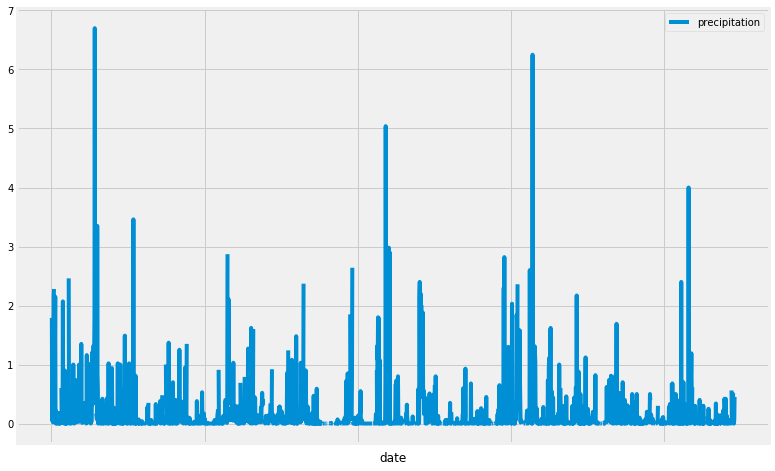

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
dateLast = str(engine.execute("SELECT max(date) FROM measurement ").fetchall())[3:13]
#year, month, date = x for x in dateLast.split("-")))
dateYearAgo = dt.date(int(dateLast.split("-")[0]), 
                      int(dateLast.split("-")[1]), 
                      int(dateLast.split("-")[2])) - dt.timedelta(days = 365)
                              
# Perform a query to retrieve the data and precipitation scores
message = "SELECT * FROM measurement WHERE date >= " + "'" + str(dateYearAgo) + "'"
df = pd.read_sql(message, session.bind)
                              
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)
 
plot_df = pd.DataFrame(df['prcp'])
plot_df.rename(columns={'prcp': "precipitation"}, inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data

plot_df.plot(kind='line', figsize=(12,8))

plt.savefig("Output/Precipitation")

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
plot_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?

query = session.query(Measurement).distinct(Measurement.station).group_by(Measurement.station).count()
query

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

query2 = session.query(Measurement, func.count(Measurement.station)).group_by(Measurement.station).all()

sortedQuery2 = sorted(query2, key = lambda x: x[1], reverse=True)
l = []
for q in sortedQuery2:
    l.append((q[0].station, q[1]))
l

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

stationId = l[0][0]
query3 = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter_by(station=stationId)
for q in query3:
    print(q)

(54.0, 85.0, 71.66378066378067)


SELECT tobs FROM measurement WHERE date >= '2016-08-23' AND station = 'USC00519281'


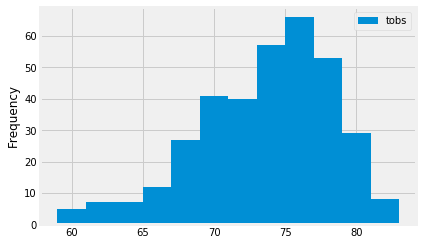

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
queryMessage = "SELECT tobs FROM measurement WHERE date >= " + "'" + str(dateYearAgo) + "'" + " AND station = " + "'" + l[0][0] + "'"
print(queryMessage)
df = pd.read_sql(queryMessage, session.bind)
df.plot.hist(bins=12)

plt.savefig("Output/Temperature Frequency")

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    
    """TMIN, TAVG, and TMAX for a list of dates.
    
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

calc_temps('2016-02-28', '2016-03-05')

[(62.0, 69.88636363636364, 80.0)]

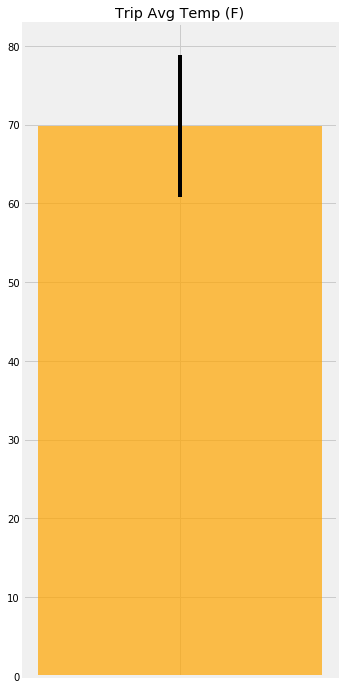

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


from statistics import stdev
tripAvgTemp = calc_temps('2016-02-28', '2016-03-05')
l = list(tripAvgTemp[0])


plt.figure(figsize=(5,12))
plt.title("Trip Avg Temp (F)")
plt.bar([''],[l[1]], yerr=[stdev(l)], color='orange', alpha=.7)

plt.savefig("Output/Trip Bar Avg Temp")

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

data = engine.execute("""SELECT station, sum(prcp), name, latitude, longitude, elevation
                FROM measurement
                JOIN station USING(station)
                WHERE date >= '2016-02-28' AND date <= '2016-03-05'
                GROUP BY station
                ORDER BY sum(prcp) desc
                """)
for row in data:
    print(row)

('USC00519523', 0.33, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00514830', 0.12000000000000001, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00516128', 0.02, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00519281', 0.01, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00513117', 0.0, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00519397', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00517948', None, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = '2016-02-28'
end = '2016-03-05'
# Use the start and end date to create a range of dates
dates = pd.date_range(start=start,end=end)
print(dates)
# Stip off the year and save a list of %m-%d strings
dates_month_day = dates.map(lambda x: x.strftime('%m-%d'))
print(dates_month_day)
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(date) for date in dates_month_day]
normals

DatetimeIndex(['2016-02-28', '2016-02-29', '2016-03-01', '2016-03-02',
               '2016-03-03', '2016-03-04', '2016-03-05'],
              dtype='datetime64[ns]', freq='D')
Index(['02-28', '02-29', '03-01', '03-02', '03-03', '03-04', '03-05'], dtype='object')


[[(65.0, 70.65517241379311, 80.0)],
 [(67.0, 71.73333333333333, 79.0)],
 [(64.0, 70.0327868852459, 76.0)],
 [(61.0, 70.36666666666666, 78.0)],
 [(60.0, 70.06896551724138, 78.0)],
 [(57.0, 69.27272727272727, 77.0)],
 [(60.0, 67.89090909090909, 76.0)]]

In [23]:
dfSplit = []

for t in normals:
    # Build dictionary to append
    df_dict = {'tmin':t[0][0] ,
            'tavg':t[0][1] ,
            'tmax':t[0][2] }
    # Append to list
    dfSplit.append(df_dict)

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Create df
df = pd.DataFrame(dfSplit, index=dates)
df.head()

,tavg,tmax,tmin
2016-02-28,70.655172,80.0,65.0
2016-02-29,71.733333,79.0,67.0
2016-03-01,70.032787,76.0,64.0
2016-03-02,70.366667,78.0,61.0
2016-03-03,70.068966,78.0,60.0


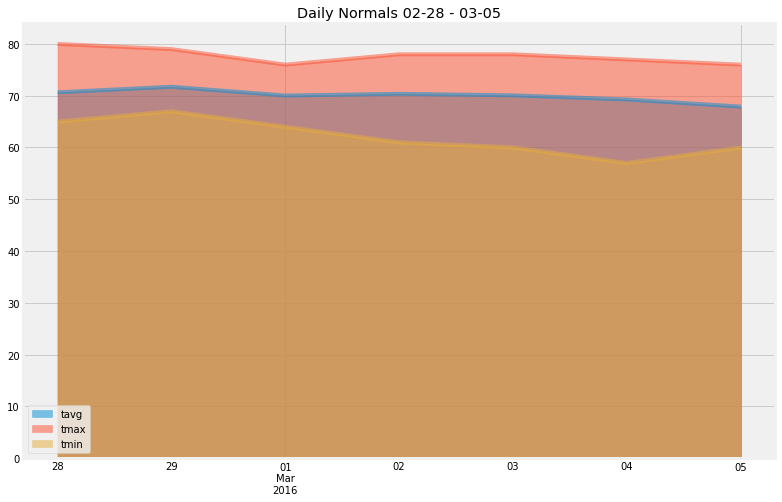

In [29]:
 # Plot the daily normals as an area plot with `stacked=False`
    
fig, ax = plt.subplots()
df.plot(ax=ax, kind='area', stacked=False, figsize=(12,8))
plt.title("Daily Normals 02-28 - 03-05")

plt.savefig("Output/DailyNormals")